In [74]:
#Selenium 4.9.0
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from msedge.selenium_tools import Edge, EdgeOptions

import re
import time
from datetime import datetime
import pandas as pd
pd.set_option("future.no_silent_downcasting", True)

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
game_id = 1245620
url_template = "https://steamcommunity.com/app/{}/reviews/?p=1&browsefilter=mostrecent&filterLanguage=english"
url = url_template.format(game_id)
print(url)

https://steamcommunity.com/app/1245620/reviews/?p=1&browsefilter=mostrecent&filterLanguage=english


In [3]:
service = Service()
options = webdriver.EdgeOptions()

language = "en-US"
options.add_argument(f"--lang={language}")

driver = webdriver.Edge(service=service, options=options)
driver.maximize_window()
driver.get(url)


In [5]:
def get_current_scroll_position(driver):
    return driver.execute_script("return window.pageYOffset;")

def scroll_to_bottom(driver):
    driver.execute_script("window.scrollTo(20, document.body.scrollHeight);")
    time.sleep(1)

def get_steam_id(card):
    profile_url = card.find_element(By.XPATH, './/div[@class="apphub_friend_block"]/div/a[2]').get_attribute('href')
    steam_id = profile_url.split('/')[-2]
    return steam_id
def scrape_review_data(card):
    date_posted_element = card.find_element(By.XPATH, './/div[@class="apphub_CardTextContent"]/div[@class="date_posted"]')
    date_posted = date_posted_element.text.strip()

    card_text_content_element = card.find_element(By.CLASS_NAME, "apphub_CardTextContent")
    review_content = card_text_content_element.text.strip()
    excluded_elements = [date_posted]

    for excluded_element in excluded_elements:
        review_content = review_content.replace(excluded_element, "")
    review_content = review_content.replace("\n", "")

    review_length = len(review_content.replace(" ", ""))

    thumb_text = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[2]').text
    play_hours = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[3]').text

    return review_content, thumb_text, review_length, play_hours, date_posted
    

In [6]:
reviews = []
steam_ids_set = set()
max_scroll_attempts = 5

try:
    last_position = get_current_scroll_position(driver)
    running = True
    while running:
        cards = driver.find_elements(By.CLASS_NAME, 'apphub_Card')

        for card in cards[-20:]:
            steam_id = get_steam_id(card)
            if steam_id in steam_ids_set:
                continue
            else:
                review = scrape_review_data(card)
                reviews.append(review)

        scroll_attempt= 0
        while scroll_attempt < max_scroll_attempts:
            scroll_to_bottom(driver)
            curr_position = get_current_scroll_position(driver)

            if curr_position == last_position:
                scroll_attempt += 1
                time.sleep(3)

                if curr_position >= 3:
                    running = False
                    break
            else:
                last_position = curr_position
                break
        
    
except Exception as e:
    print(e)

finally:
    driver.quit()

In [86]:
df = pd.DataFrame(reviews, columns= ['ReviewText', 'Review', 'ReviewLength', 'PlayHours', 'DatePosted'])

In [8]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted
0,I like to die and I like to hit things,Recommended,29,111.2 hrs on record,Posted: March 30
1,I hate it because I'm bad.,Recommended,21,52.6 hrs on record,Posted: March 30
2,You get better till you quit15/10 will masochi...,Recommended,46,100.3 hrs on record,Posted: March 30
3,MASTERPIECE (McLOVIN APPROVED),Recommended,28,202.2 hrs on record,Posted: March 30
4,hard af to get armor and only armor lol,Recommended,31,8.8 hrs on record,Posted: March 30


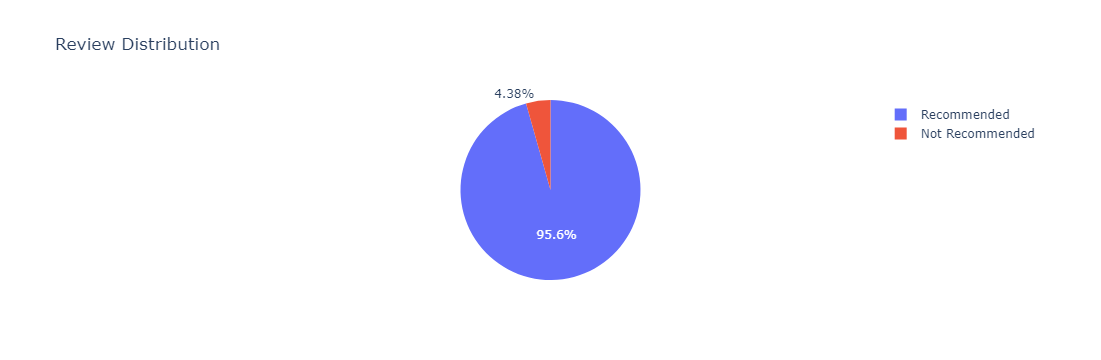

In [89]:
review_counts = df['Review'].value_counts()
px.pie(review_counts, values=review_counts, names=review_counts.index, title='Review Distribution')

In [12]:
df['PlayHours'] = df['PlayHours'].map(lambda x: re.sub(' hrs on record', '', x))
df['PlayHours'] = df['PlayHours'].map(lambda x: re.sub(',', '', x)).astype(float)

In [13]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted
0,I like to die and I like to hit things,Recommended,29,111.2,Posted: March 30
1,I hate it because I'm bad.,Recommended,21,52.6,Posted: March 30
2,You get better till you quit15/10 will masochi...,Recommended,46,100.3,Posted: March 30
3,MASTERPIECE (McLOVIN APPROVED),Recommended,28,202.2,Posted: March 30
4,hard af to get armor and only armor lol,Recommended,31,8.8,Posted: March 30


In [14]:
df['DatePosted'] = df['DatePosted'].map(lambda x: re.sub('Posted: ', '', x))

In [15]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted
0,I like to die and I like to hit things,Recommended,29,111.2,March 30
1,I hate it because I'm bad.,Recommended,21,52.6,March 30
2,You get better till you quit15/10 will masochi...,Recommended,46,100.3,March 30
3,MASTERPIECE (McLOVIN APPROVED),Recommended,28,202.2,March 30
4,hard af to get armor and only armor lol,Recommended,31,8.8,March 30


In [16]:
month_mapping = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}

In [17]:
df[['Month', 'Day']] = df['DatePosted'].str.extract(r'(\w+) (\d+)', expand=True)

In [18]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Month,Day
0,I like to die and I like to hit things,Recommended,29,111.2,March 30,March,30
1,I hate it because I'm bad.,Recommended,21,52.6,March 30,March,30
2,You get better till you quit15/10 will masochi...,Recommended,46,100.3,March 30,March,30
3,MASTERPIECE (McLOVIN APPROVED),Recommended,28,202.2,March 30,March,30
4,hard af to get armor and only armor lol,Recommended,31,8.8,March 30,March,30


In [19]:
df['Month'] = df['Month'].map(month_mapping)

In [20]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted,Month,Day
0,I like to die and I like to hit things,Recommended,29,111.2,March 30,03,30
1,I hate it because I'm bad.,Recommended,21,52.6,March 30,03,30
2,You get better till you quit15/10 will masochi...,Recommended,46,100.3,March 30,03,30
3,MASTERPIECE (McLOVIN APPROVED),Recommended,28,202.2,March 30,03,30
4,hard af to get armor and only armor lol,Recommended,31,8.8,March 30,03,30


In [21]:
df['DatePosted'] = df['Month'] + '/' + df['Day'] + '/2024'
df['DatePosted'] = pd.to_datetime(df['DatePosted'], format='%m/%d/%Y').dt.strftime('%m-%d-%Y')
df = df.drop(['Month', 'Day'], axis=1)

In [22]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted
0,I like to die and I like to hit things,Recommended,29,111.2,03-30-2024
1,I hate it because I'm bad.,Recommended,21,52.6,03-30-2024
2,You get better till you quit15/10 will masochi...,Recommended,46,100.3,03-30-2024
3,MASTERPIECE (McLOVIN APPROVED),Recommended,28,202.2,03-30-2024
4,hard af to get armor and only armor lol,Recommended,31,8.8,03-30-2024


In [23]:
df.to_csv('game_reviews.csv', encoding='utf-8', sep=';', index=False)

In [37]:
def remove_stopword(sentences, stopwords):
    filtered_words = [item for item in sentences if item not in stopwords]
    return ' '.join(filtered_words)

In [43]:
stopwords = stopwords.words('english')
df['cleanedReviewText'] = df['ReviewText'].astype(str).apply(lambda x: remove_stopwords(x.split(), stopwords))

In [44]:
df[['ReviewText', 'cleanedReviewText']]

,ReviewText,cleanedReviewText
0,I like to die and I like to hit things,I like die I like hit things
1,I hate it because I'm bad.,I hate I'm bad.
2,You get better till you quit15/10 will masochi...,You get better till quit15/10 masochist
3,MASTERPIECE (McLOVIN APPROVED),MASTERPIECE (McLOVIN APPROVED)
4,hard af to get armor and only armor lol,hard af get armor armor lol
...,...,...
1845,Rannala,Rannala
1846,haha 69 hours,haha 69 hours
1847,"""Like butter scraped over too much bread.""From...","""Like butter scraped much bread.""FromSoft forg..."
1848,"""+dopest dope i ever smoked""","""+dopest dope ever smoked"""


In [45]:
example = df['cleanedReviewText'][1]
example

"I hate I'm bad."

In [48]:
tokens = nltk.word_tokenize(example)
tokens

['I', 'hate', 'I', "'m", 'bad', '.']

In [50]:
tagged = nltk.pos_tag(tokens)
tagged

[('I', 'PRP'),
 ('hate', 'VBP'),
 ('I', 'PRP'),
 ("'m", 'VBP'),
 ('bad', 'JJ'),
 ('.', '.')]

In [55]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [56]:
sie = SentimentIntensityAnalyzer()

In [60]:
sie.polarity_scores('I love this game') #positive

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}

In [61]:
sie.polarity_scores('I hate this game') #negative

{'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.5719}

In [63]:
df['PolarityScores'] = [sie.polarity_scores(x)['compound'] for x in df['cleanedReviewText']]

In [64]:
df.head()

,ReviewText,Review,ReviewLength,PlayHours,DatePosted,cleanedReviewText,PolarityScores
0,I like to die and I like to hit things,Recommended,29,111.2,03-30-2024,I like die I like hit things,0.0258
1,I hate it because I'm bad.,Recommended,21,52.6,03-30-2024,I hate I'm bad.,-0.8020
2,You get better till you quit15/10 will masochi...,Recommended,46,100.3,03-30-2024,You get better till quit15/10 masochist,0.0516
3,MASTERPIECE (McLOVIN APPROVED),Recommended,28,202.2,03-30-2024,MASTERPIECE (McLOVIN APPROVED),0.7034
4,hard af to get armor and only armor lol,Recommended,31,8.8,03-30-2024,hard af get armor armor lol,0.3400


In [75]:
df['ReviewValue'] = df['Review'].replace({'Recommended': 1, 'Not Recommended': 0})

In [76]:
df[['ReviewValue', 'PolarityScores']].corr(method='pearson')

,ReviewValue,PolarityScores
ReviewValue,1.000000,0.135017
PolarityScores,0.135017,1.000000


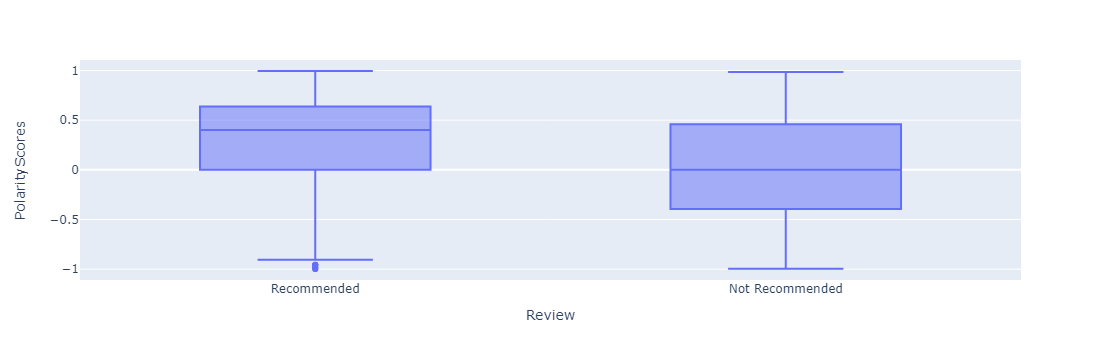

In [77]:
px.box(df, x='Review', y='PolarityScores')

In [80]:
def plot_wordcloud(series, output_filename='wordcloud'):
    
    wordcloud = WordCloud().generate(' '.join(series.astype(str)))
    
    wordcloud.to_file(output_filename + '.png')
    
    plt.imshow(wordcloud, interpolation='bilinear')
    
    plt.axis("off")

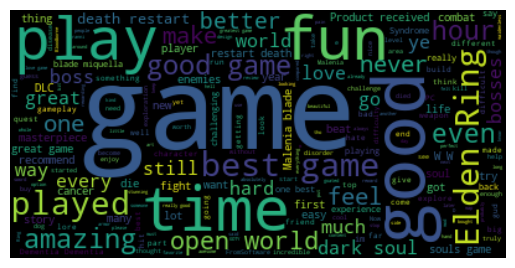

In [81]:
plot_wordcloud(df['cleanedReviewText'])